In [1]:
## Importing all package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow_hub as hb
from tensorflow import keras
import skimage
import sklearn
import cv2
from google.colab import drive
import random
import os

In [2]:
print("Version of tensorflow:",tf.__version__)
print("Tensorflow_hub version:",hb.__version__)
print("GPU," "availabe(yesss)" if tf.config.list_physical_devices("GPU") else "not availabel" )

Version of tensorflow: 2.12.0
Tensorflow_hub version: 0.14.0
GPU,availabe(yesss)


In [3]:
drive.mount('/content/drive')
training_data = r"/content/drive/MyDrive/Intel_Image_classification/_train/"
testing_data =  r"/content/drive/MyDrive/Intel_Image_classification/_test/"

checking_forest_data = r"/content/drive/MyDrive/Intel_Image_classification/seg_train/forest/"
checking_sea_data = r"/content/drive/MyDrive/Intel_Image_classification/seg_train/sea/"
checking_building_data = r"/content/drive/MyDrive/Intel_Image_classification/seg_train/buildings/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Function to Display images

In [4]:
def plot_image(data_set):
  plt.figure(figsize=(20,20))
  for i in range(4):
    file = random.choice(os.listdir(data_set))
    image_path = os.path.join(data_set,file)
    img = mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)


Importing random images

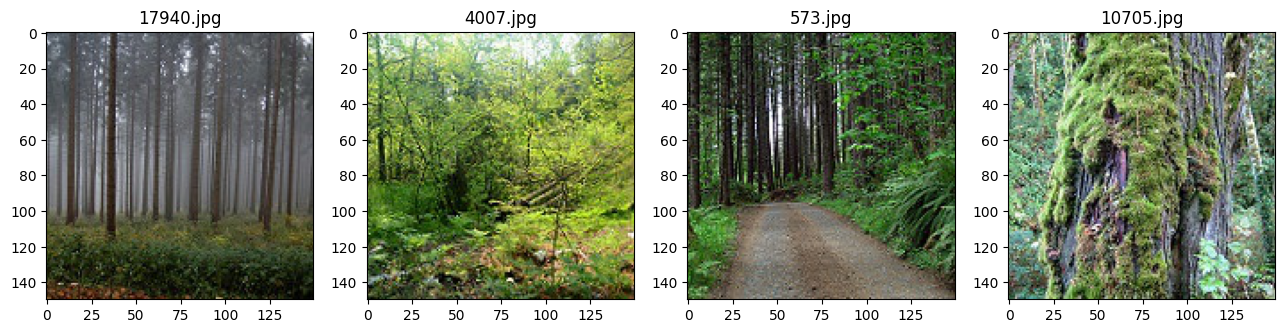

In [5]:
# Ploting the Image of  traning data
plot_image(checking_forest_data)

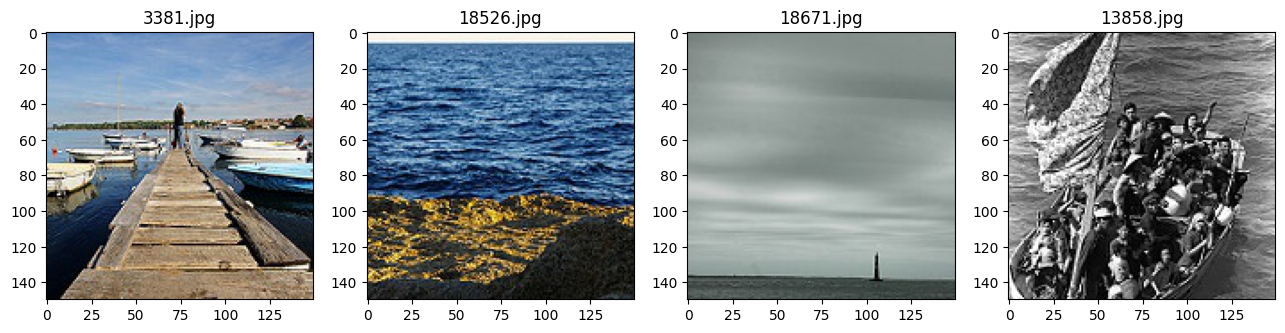

In [6]:
plot_image(checking_sea_data)

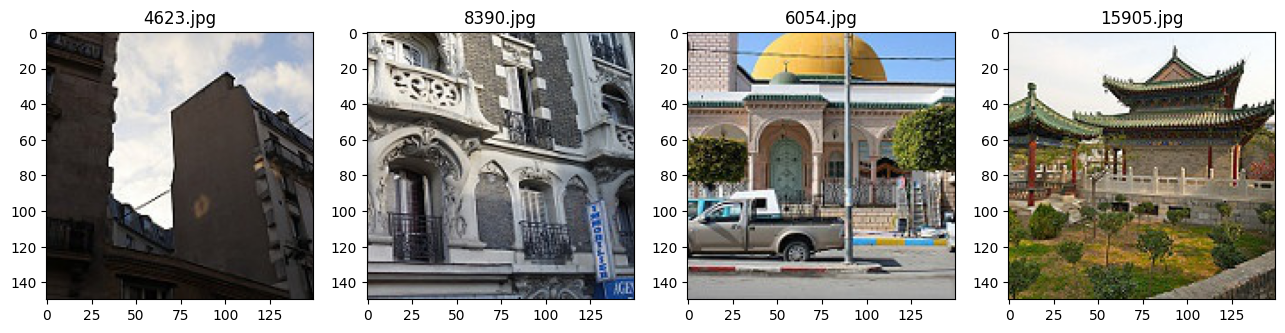

In [7]:

plot_image(checking_building_data)

## Defining class_names and their labels

In [8]:
class_name = ['mountain','street','glacier','buildings','sea','forest']
class_name_label = {}

for i, class_name in enumerate(class_name):
    class_name_label[class_name] = i

In [9]:
print(class_name_label)

{'mountain': 0, 'street': 1, 'glacier': 2, 'buildings': 3, 'sea': 4, 'forest': 5}


In [10]:
len(class_name_label)

6

Resize the Image label

In [11]:
## Resize the the image
Image_size = 150

## loading and Preprocessing the Data

In [12]:

def load_data():
  directory_path = "/content/drive/MyDrive/Intel_Image_classification/"
  type_of_data = ["seg_train", "seg_test"]

  output=[]   # this will contain all the datas

  #loop through all the folder for each image
  for cat in type_of_data:

    path = os.path.join(directory_path,cat)

    # to store image and labels after reading through each folder
    images = []
    labels =[]

    print("Loading images...".format(cat))

    for folder in os.listdir(path):
      print("Loading.. ",folder)
      label = class_name_label[folder]
      for file in os.listdir(os.path.join(path,folder)):

        image_path = os.path.join(os.path.join(path,folder),file) # fetching the path of image

        ##opening and converting image to tensor

        image = cv2.imread(image_path)
        #Turn the jpeg image into RGB(3)color channels
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        # Normalization image
        image = tf.image.convert_image_dtype(image,tf.float32)

        ##Rezise image according to model
        image = tf.image.resize(image,size=[Image_size, Image_size])


        ## appending the images and labe
        images.append(image)
        labels.append(label)

    images = tf.image.convert_image_dtype(images,tf.float32)
    labels = tf.image.convert_image_dtype(labels,tf.int32)

    output.append((images, labels))

  return output





In [13]:
(train_images,train_labels) ,(test_images,test_labels) = load_data()

Loading images...
Loading..  street
Loading..  sea
Loading..  mountain
Loading..  glacier
Loading..  forest
Loading..  buildings
Loading images...
Loading..  mountain
Loading..  forest
Loading..  sea
Loading..  glacier
Loading..  buildings
Loading..  street


In [14]:
len(train_images) , len(train_labels), len(test_images), len(test_labels)

(14034, 14034, 3010, 3010)

In [15]:
# Creating an X and Y variable for traning model with 1000 images

NUM_IMAGES = 1000

X= train_images
Y = train_labels

In [16]:
len(X), len(Y),

(14034, 14034)

In [17]:
X.shape,Y.shape

(TensorShape([14034, 150, 150, 3]), TensorShape([14034]))

In [18]:
def get_image_label(image, labels):
  image
  label = tf.one_hot(labels,depth =6)
  return image, label

### Creating a function for Batch

In [19]:
BATCH_SIZE = 32;
def create_data_batches(X, Y=None, batch_size=BATCH_SIZE, test_data= False):

  # If the data is testing data set, we will not shuffle
  if test_data:
    print("Creating the testing data batches !")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(Y)))  #where X = images and Y = labels for there images
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  ## IF the data is training data set  we will shuffer

  else:
    print("Creating the trainning data batches !")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(Y)))
    ## shuffling the traning data set
    data = data.shuffle(buffer_size = len(X))

    data = data.map(get_image_label)   # create (image,label) to tuples

    data_batch = data.batch(BATCH_SIZE)

  return data_batch

## Conveting the data into batches

In [20]:
train_Data_batches = create_data_batches(train_images,train_labels,test_data=False)
testing_Data_batches = create_data_batches(test_images, test_labels, test_data=True)

Creating the trainning data batches !
Creating the testing data batches !


In [21]:
##getting the specification of our data sets
train_Data_batches.element_spec, testing_Data_batches.element_spec

((TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)))

In [22]:
print(train_labels)

tf.Tensor([1 1 1 ... 3 3 3], shape=(14034,), dtype=int32)


## Function to Visualize the image of traning data set

In [23]:
def visual_image(images, labels):
  plt.figure(figsize=(15, 15))

  for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        label_index = labels[i].argmax()  # Assuming labels are in one-hot encoded format
        label_name = [k for k, v in class_name_label.items() if v == label_index]
        if len(label_name) > 0:
            plt.title(label_name[0])
        else:
            plt.title('Unknown')
        plt.axis("off")

In [24]:
tr_image, tr_labels = next(train_Data_batches.as_numpy_iterator())

In [25]:
vl_image, vl_labels = next(testing_Data_batches.as_numpy_iterator())

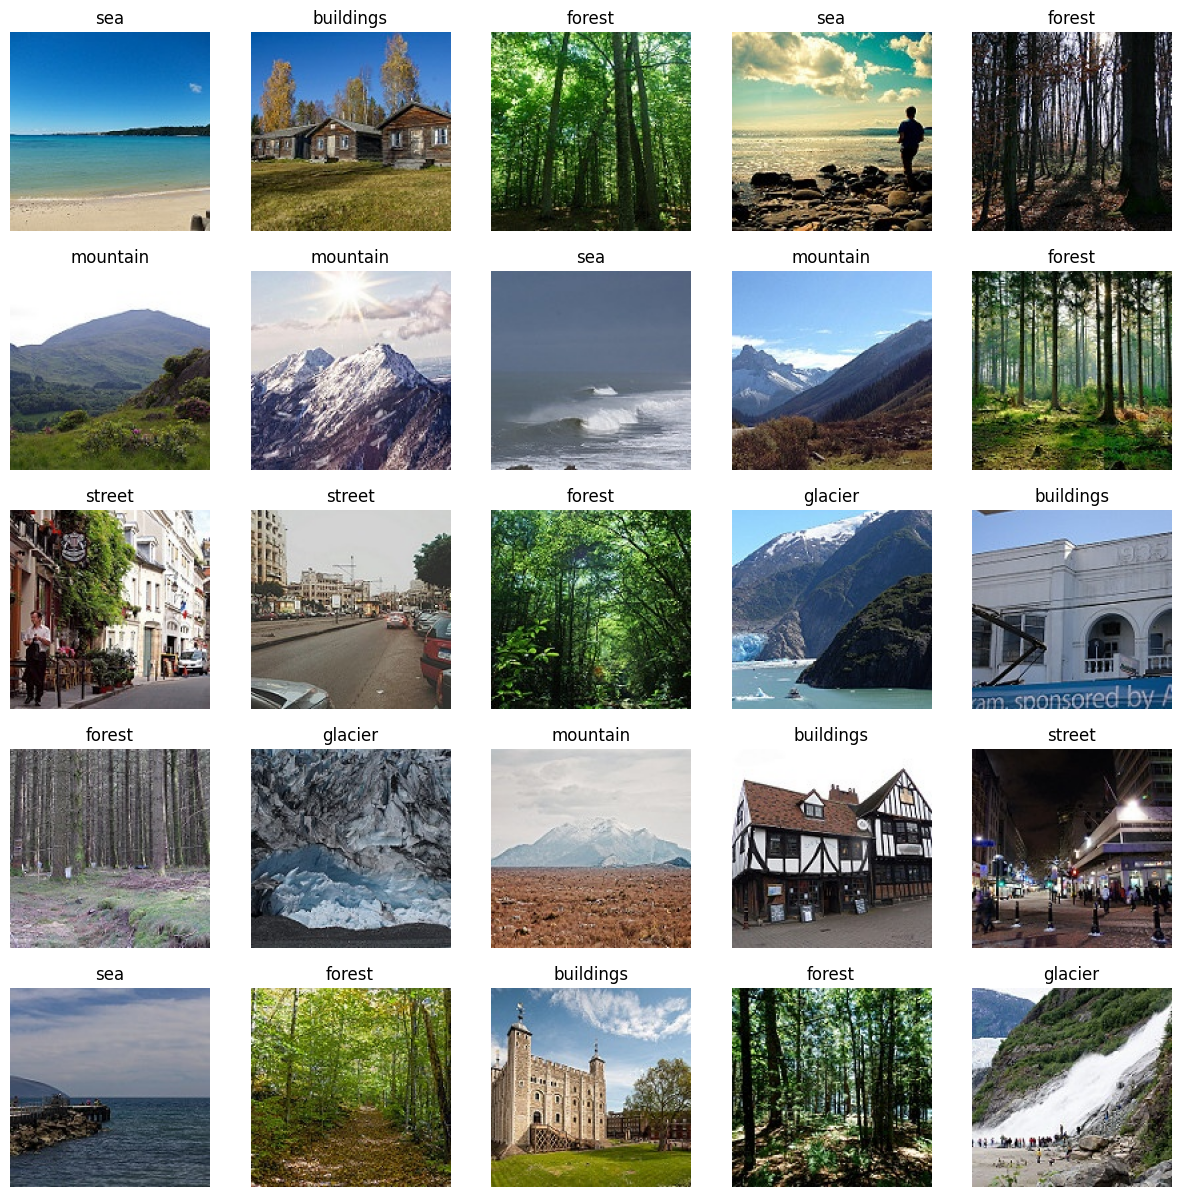

In [26]:
visual_image(tr_image,tr_labels)

### Creating Input/Output shape

In [27]:
## Defing the input and output shape for model
## Model used : https://tfhub.dev/google/imagenet/inception_v1/classification/5(Inception V1)

INPUT_SIZE = [None, 150,150,3]

OUTPUT_SIZE = len(class_name_label)

MODEL_URL = "https://tfhub.dev/google/imagenet/inception_v1/classification/5"

### Building Model (Inception V1)

In [28]:
def create_model(input_size= INPUT_SIZE, output_size =OUTPUT_SIZE, model= MODEL_URL):

      model = tf.keras.Sequential([
      hb.KerasLayer(MODEL_URL), ## layer=1 , input layer
      #tf.keras.layers.Dense(128,activation = tf.nn.relu),
      tf.keras.layers.Dense(units = OUTPUT_SIZE,activation= "softmax") ## layer 2 (output layer)

      ])

     ## compile the model

      model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(), ## minimize the loss (more the loss worst the model is trianing and gusseing)
      optimizer = tf.keras.optimizers.Adam(),  ## help to reduce the loss function
      metrics = ["accuracy"],

  )

        ## Build the model
      model.build(INPUT_SIZE)

      return model

In [29]:
inception_model = create_model()

In [30]:
inception_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              6633209   
                                                                 
 dense (Dense)               (None, 6)                 6012      
                                                                 
Total params: 6,639,221
Trainable params: 6,012
Non-trainable params: 6,633,209
_________________________________________________________________


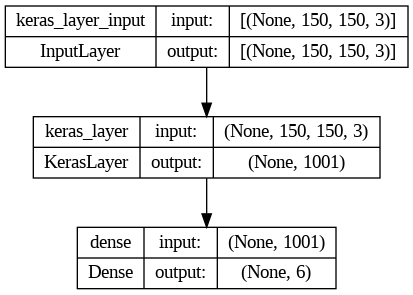

In [31]:
## Helps to see the graph of the our CNN  layers
tf.keras.utils.plot_model(inception_model,show_shapes=True)


In [32]:
## Creating Early_callbacks

Early_callback_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience =3)

In [33]:
#train_Data_batches

### Creating a function for train Mode

In [34]:
model = inception_model.fit(train_Data_batches,epochs=5,validation_data=testing_Data_batches,validation_freq=1,callbacks=[Early_callback_stop])


Epoch 1/5
439/439 [==============================] - 21s 31ms/step - loss: 0.3872 - accuracy: 0.8675 - val_loss: 0.3043 - val_accuracy: 0.9000
Epoch 2/5
439/439 [==============================] - 13s 25ms/step - loss: 0.2890 - accuracy: 0.8981 - val_loss: 0.2939 - val_accuracy: 0.8953
Epoch 3/5
439/439 [==============================] - 12s 26ms/step - loss: 0.2655 - accuracy: 0.9049 - val_loss: 0.2763 - val_accuracy: 0.9017
Epoch 4/5
439/439 [==============================] - 13s 26ms/step - loss: 0.2521 - accuracy: 0.9101 - val_loss: 0.2893 - val_accuracy: 0.8987
Epoch 5/5
439/439 [==============================] - 13s 27ms/step - loss: 0.2504 - accuracy: 0.9141 - val_loss: 0.3094 - val_accuracy: 0.8987


In [35]:
"""
Number_EPOCS = 10
def train_model():

  model_Incep = create_model()  # creating the model
  model_Incep.fit(train_Data_batches,epochs= Number_EPOCS,validation_data = testing_Data_batches,validation_freq=1, callbacks=[Early_callback_stop])

  return model_Incep;

"""

'\nNumber_EPOCS = 10\ndef train_model():\n\n  model_Incep = create_model()  # creating the model\n  model_Incep.fit(train_Data_batches,epochs= Number_EPOCS,validation_data = testing_Data_batches,validation_freq=1, callbacks=[Early_callback_stop])\n\n  return model_Incep;\n\n'

In [36]:
##Model Fitting
#Final_model_Incep  = train_model()

## Plotting Accuracy

In [37]:
acc = model.history['accuracy']
val_acc = model.history['val_accuracy']
loss = model.history['loss']
val_loss = model.history['val_loss']
epochs = model.epoch

Text(0, 0.5, 'Accuracy')

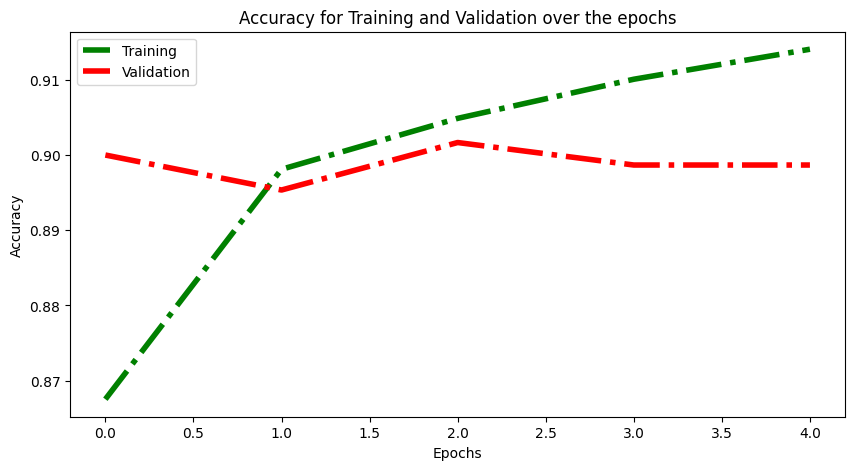

In [38]:
plt.figure(figsize=(10,5),frameon=False)
plt.plot(epochs,acc,c='g',ls='-.',lw='4',label='Training')
plt.plot(epochs,val_acc,c='r',ls='-.',lw='4',label='Validation')
plt.legend()
plt.title('Accuracy for Training and Validation over the epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

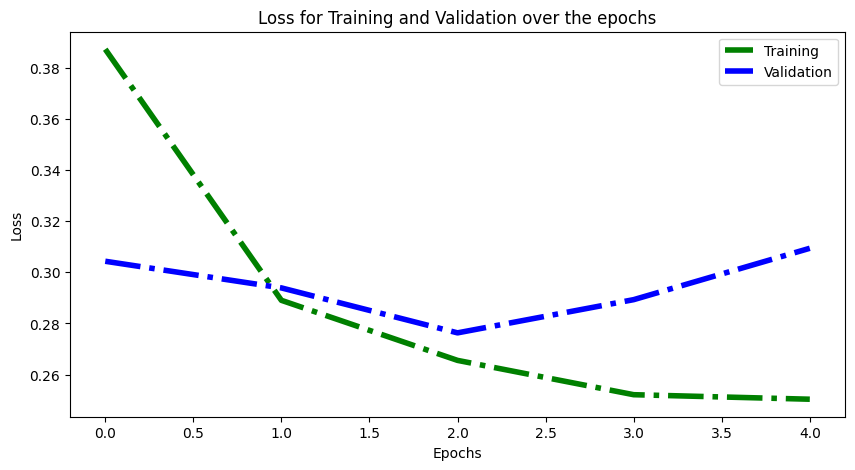

In [39]:
plt.figure(figsize=(10,5))
plt.plot(epochs,loss,c='g',ls='-.',lw='4',label='Training')
plt.plot(epochs,val_loss,c='b',ls='-.',lw='4',label='Validation')
plt.legend()
plt.title('Loss for Training and Validation over the epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [41]:
predictions = inception_model.predict(test_images)
pre_labels = np.argmax(predictions,axis=1)

95/95 [==============================] - 3s 23ms/step


## Classification Report

In [43]:
from sklearn.metrics import classification_report
print(classification_report(test_labels,pre_labels))


              precision    recall  f1-score   support

           0       0.83      0.86      0.84       525
           1       0.89      0.96      0.92       501
           2       0.85      0.82      0.83       553
           3       0.94      0.87      0.90       437
           4       0.97      0.91      0.94       520
           5       0.94      0.99      0.97       474

    accuracy                           0.90      3010
   macro avg       0.90      0.90      0.90      3010
weighted avg       0.90      0.90      0.90      3010



### Saving and loading model

In [46]:
def save_model(model, suffix= None):
  modeldir = os.path.join ("/content/drive/MyDrive/Intel_Image_classification/models")
  model_Path = modeldir + "_" +suffix +".h5"  # save the formate of model
  model.save(model_Path)
  return model_Path

In [47]:
save_model(inception_model, suffix = "inception_intel_image_model")

'/content/drive/MyDrive/Intel_Image_classification/models_inception_intel_image_model.h5'